In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from timestamps import BeeTimestamps, segments_to_features_and_labels, randomize_segments, balance_segments
import matplotlib.pyplot as plt
import models

SEED = 2
SEGMENT_SIZE = 24
events = ['died', 'wakeup', 'normal', 'harversting']
feature_names = ['weight_kg_3_pct', 'month', 'temp_ratio_oi']
timestamps = BeeTimestamps(
    'timestamps-v4.json', 
    './dataset/transformed_populated/interval_240m',
    events=events, 
    features=feature_names,
    step=1
)
segments = timestamps.get_segments_for_major_events(
    segment_size=SEGMENT_SIZE, 
    hours=52
)
print("Segments: ", len(segments))
for event in events:
    print(f"Segments with {event}: {len([segment for segment in segments if segment.get_label()[event] == 1])}")

Segments:  902
Segments with died: 150
Segments with wakeup: 20
Segments with normal: 677
Segments with harversting: 55


In [2]:
random_segments = randomize_segments(segments, seed=SEED)
balanced_segments = balance_segments(random_segments, events=events, min_count=60)
print(f"Balanced segments: {len(balanced_segments)}")

features, labels = segments_to_features_and_labels(balanced_segments)
print(f"Features: {features.shape}, Labels: {labels.shape}")
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=SEED)
sequence_length = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]
print(f"Sequence length: {sequence_length}, N features: {n_features}, N outputs: {n_outputs}")

Balanced segments: 195
Features: (195, 24, 3), Labels: (195, 4)
Sequence length: 24, N features: 3, N outputs: 4


In [3]:
train_positive = np.sum(np.any(y_train == 1, axis=1))
test_positive = np.sum(np.any(y_test == 1, axis=1))
print(f"Training samples with positive labels: {train_positive} out of {len(y_train)} ({train_positive/len(y_train)*100:.1f}%)")
print(f"Test samples with positive labels: {test_positive} out of {len(y_test)} ({test_positive/len(y_test)*100:.1f}%)")

Training samples with positive labels: 156 out of 156 (100.0%)
Test samples with positive labels: 39 out of 39 (100.0%)


In [4]:
model = models.lstm_v2_categorical(
    SEGMENT_SIZE=SEGMENT_SIZE, 
    sequence_length=sequence_length, 
    n_features=n_features, 
    n_outputs=n_outputs
)

history = model.fit(X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[models.reduce_lr]
    # callbacks=[models.early_stopping, models.reduce_lr]
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4445 - loss: 5.9778 - precision: 0.4444 - recall: 0.3205 - val_accuracy: 0.2188 - val_loss: 5.8332 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5799 - loss: 5.5416 - precision: 0.6139 - recall: 0.4925 - val_accuracy: 0.2188 - val_loss: 5.7758 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6600 - loss: 5.2533 - precision: 0.7055 - recall: 0.6174 - val_accuracy: 0.2188 - val_loss: 5.6521 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7503 - loss: 4.8286 - precision: 0.8486 - recall: 0.6885 - val_accuracy: 0.2188 - val_loss: 5.5280 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 5/100
8/8 ━━━━━━━━

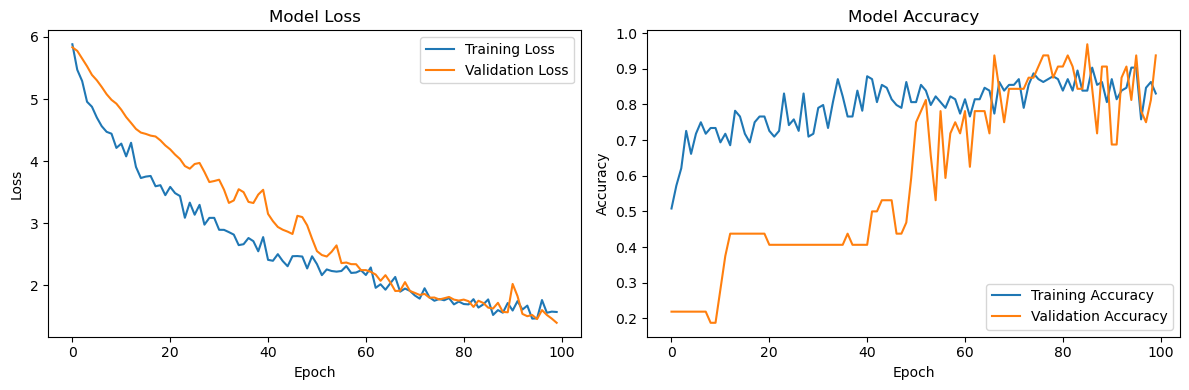

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9725 - loss: 1.3870 - precision: 0.9709 - recall: 0.9175  

Test accuracy: 0.9744


In [5]:
models.visualize_training(history)
# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_accuracy:.4f}')

In [6]:
# For multi-label classification, we need to evaluate each class separately
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report for each event type
for i, event in enumerate(events):
    print(f"\nClassification Report for {event}:")
    print(classification_report(y_test[:, i], y_pred_classes[:, i]))
    
    # Calculate and print accuracy for this event
    accuracy = accuracy_score(y_test[:, i], y_pred_classes[:, i])
    print(f"Accuracy for {event}: {accuracy:.4f}")

# Print overall accuracy (all classes predicted correctly)
overall_accuracy = np.all(y_test == y_pred_classes, axis=1).mean()
print(f"\nOverall accuracy (all classes correct): {overall_accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

Classification Report for died:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       1.00      0.88      0.93        16

    accuracy                           0.95        39
   macro avg       0.96      0.94      0.95        39
weighted avg       0.95      0.95      0.95        39

Accuracy for died: 0.9487

Classification Report for wakeup:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00         2

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39

Accuracy for wakeup: 1.0000

Classification Report for normal:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.91      0.91      0.

In [7]:
# Find indices where predictions don't match actual values
incorrect_indices = np.where(~np.all(y_test == y_pred_classes, axis=1))[0]

print("\nIncorrect Predictions:")
print("-" * 80)
print(f"{'Index':<10}{'Expected':<40}{'Predicted':<40}")
print("-" * 80)

for idx in incorrect_indices:
    # Get the actual and predicted labels for this sample
    actual = y_test[idx]
    predicted = y_pred_classes[idx]
    
    # Convert to event names
    actual_events = [events[i] for i in range(len(events)) if actual[i] == 1]
    predicted_events = [events[i] for i in range(len(events)) if predicted[i] == 1]
    
    # Format as strings
    actual_str = ", ".join(actual_events) if actual_events else "None"
    predicted_str = ", ".join(predicted_events) if predicted_events else "None"
    
    print(f"{idx:<10}{actual_str:<40}{predicted_str:<40}")

print(f"\nTotal incorrect predictions: {len(incorrect_indices)} out of {len(y_test)} test samples")



Incorrect Predictions:
--------------------------------------------------------------------------------
Index     Expected                                Predicted                               
--------------------------------------------------------------------------------
6         died                                    None                                    
15        died                                    normal                                  
27        normal                                  None                                    

Total incorrect predictions: 3 out of 39 test samples


0 weight_kg_3_pct [-0.01886792  9.          1.09027128]
2 temp_ratio [-0.01848917  9.          1.11335784]


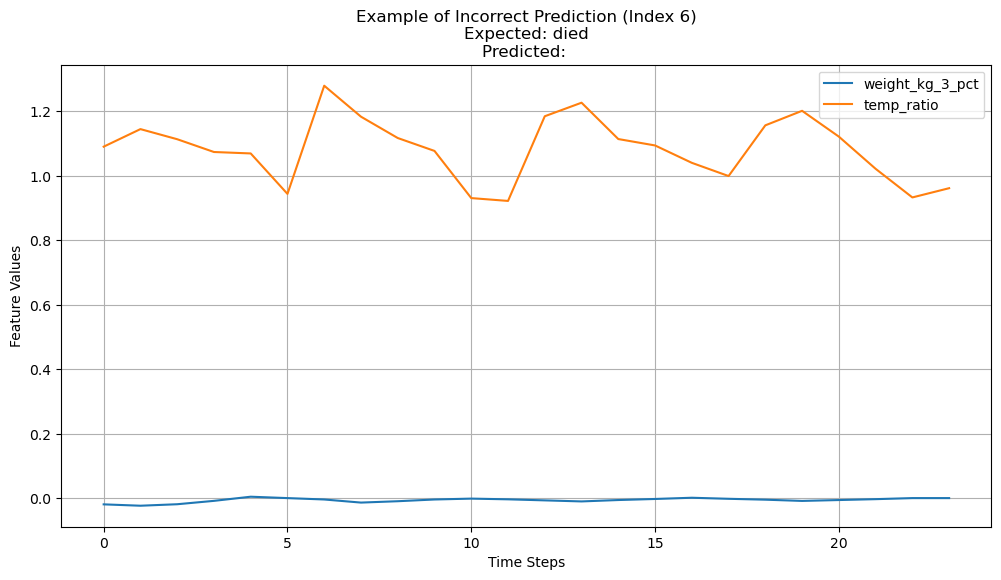

In [13]:
# Plot a few examples of incorrect predictions
plt.figure(figsize=(12, 6))

# Get the first incorrect prediction
idx = incorrect_indices[0]

# Plot the features for this example
for i, feature in enumerate(feature_names):
    if (feature == 'month'):
        continue
    print(i, feature, X_test[idx][i])
    plt.plot(X_test[idx][:, i], label=feature)

#plt.plot(X_test[idx])

plt.title(f'Example of Incorrect Prediction (Index {idx})\n' + 
          f'Expected: {", ".join([events[i] for i in range(len(events)) if y_test[idx][i] == 1])}\n' +
          f'Predicted: {", ".join([events[i] for i in range(len(events)) if y_pred_classes[idx][i] == 1])}')
plt.xlabel('Time Steps')
plt.ylabel('Feature Values')
plt.grid(True)
plt.legend()
plt.show()


